# Fourier model for approximating QVCs


In [1]:
import torch
import math
import numpy as np
import torch.nn as nn
from visualizer import *
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
transform=transforms.Compose([
            transforms.Resize(size=18),
            transforms.CenterCrop(size=16),
            transforms.ToTensor()
        ])

In [3]:
train = datasets.ImageFolder(root='./dataset/dataset_train', transform=transform)
test = datasets.ImageFolder(root='./dataset/dataset_test', transform=transform)
rng = np.random.default_rng(seed=123401234)
num_classes = 4

train_loader = DataLoader(train, batch_size=len(train))
test_loader = DataLoader(test, batch_size=len(test))

train_set_img, train_set_labels = next(iter(train_loader))
test_set_img, test_set_labels = next(iter(test_loader))

train_set_img = torch.squeeze(train_set_img[:,0,:,:])
test_set_img = torch.squeeze(test_set_img[:,0,:,:])


# permute the arrays so we can visualize different classes with first 10 imgs
rand_idx_train = rng.permutation(len(train_set_img))
X_train = train_set_img[rand_idx_train]
Y_train = train_set_labels[rand_idx_train]

rand_idx_test = rng.permutation(len(test_set_img))
X_test = test_set_img[rand_idx_test]
Y_test = test_set_labels[rand_idx_test]


In [4]:
"""
train = datasets.MNIST('./dataset', train=True, download=True,
                       transform=transform)
test = datasets.MNIST('./dataset', train=False,
                       transform=transform)

train_loader = DataLoader(train, batch_size=len(train))
test_loader = DataLoader(test, batch_size=len(test))

train_set_img, train_set_labels = next(iter(train_loader))
test_set_img, test_set_labels = next(iter(test_loader))

X_train = train_set_img
X_test = test_set_img
Y_train = train_set_labels
Y_test = test_set_labels
"""

"\ntrain = datasets.MNIST('./dataset', train=True, download=True,\n                       transform=transform)\ntest = datasets.MNIST('./dataset', train=False,\n                       transform=transform)\n\ntrain_loader = DataLoader(train, batch_size=len(train))\ntest_loader = DataLoader(test, batch_size=len(test))\n\ntrain_set_img, train_set_labels = next(iter(train_loader))\ntest_set_img, test_set_labels = next(iter(test_loader))\n\nX_train = train_set_img\nX_test = test_set_img\nY_train = train_set_labels\nY_test = test_set_labels\n"

Input shapes: X_train_input: torch.Size([1000, 256]), X_test_input: torch.Size([200, 256]),Y_train_input: torch.Size([1000]), Y_test_input: torch.Size([200])
number of samples with label 0 in train set: 250
number of samples with label 1 in train set: 250
number of samples with label 2 in train set: 250
number of samples with label 3 in train set: 250
number of samples with label 0 in test set: 50
number of samples with label 1 in test set: 50
number of samples with label 2 in test set: 50
number of samples with label 3 in test set: 50
first 10 img of train set:


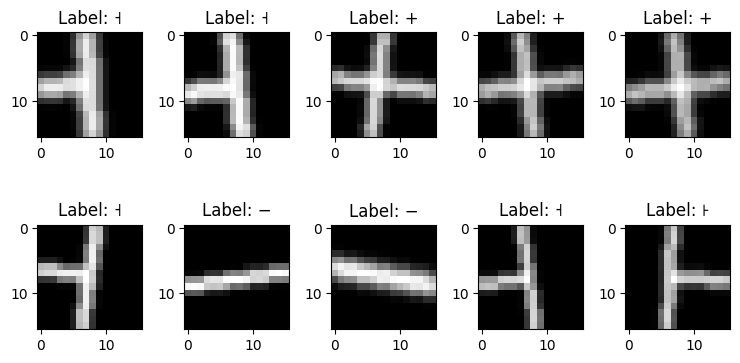

first 10 img of test set:


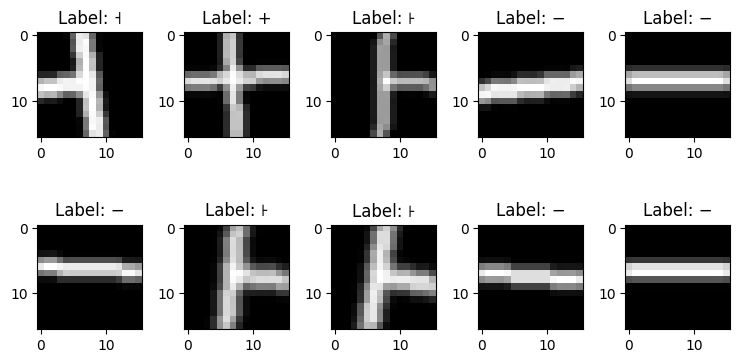

In [5]:
### Visualize some img

classes = [0,1,2,3]
num_classes = len(classes)

def count_occurrences(x,y, set):
    for label in range(len(classes)):
        occurrences = x[y == label].shape[0]
        print(f"number of samples with label {label} in {set} set: {occurrences}")

padding = 0
X_train_input = X_train
Y_train_input = Y_train
X_test_input = X_test
Y_test_input = Y_test

X_train_orig = np.copy(X_train_input.detach().numpy())
X_test_orig = np.copy(X_test_input.detach().numpy())

X_train_input = torch.reshape(X_train_input,(X_train_input.shape[0], -1))
X_test_input = torch.reshape(X_test_input,(X_test_input.shape[0], -1))
    
if padding > 0:
    print("WHY ARE U USING PADDING :(")

print(f"Input shapes: X_train_input: {X_train_input.shape}, X_test_input: {X_test_input.shape},"
            +f"Y_train_input: {Y_train_input.shape}, Y_test_input: {Y_test_input.shape}") 

count_occurrences(X_train_input,Y_train_input, "train")
count_occurrences(X_test_input,Y_test_input, "test")

print('first 10 img of train set:')
show_images(X_train_orig, Y_train_input)

print('first 10 img of test set:')
show_images(X_test_orig, Y_test_input)


## Model architecture for Fourier network

In [6]:
TRAINABLE_ENC = True

criterion = nn.CrossEntropyLoss()

def tree_sample_RFF(D, d, num_reup):
    """ returns (Dxd) samples omega ∈ Omega """ 
    #assert num_reup%2 == 0
    # step 1: get array of all possible sums of eigenvalues (for Pauli encoding, this is [-L,L])
    eigval_sums = np.linspace(-num_reup//2, num_reup//2, num=num_reup+1, endpoint=True)
    # step 2: sample L times and add the sampled values, this is tree sampling
    sampled_vals = rng.choice(a=eigval_sums, size=(D,d))
    for i in range(num_reup-1):
        sampled_vals += rng.choice(eigval_sums, size=(D,d))
    return torch.tensor(sampled_vals).double()

if TRAINABLE_ENC:
    ##############################################################################
    hidden_size_half = 32    # will be double this size due to sin and cos layer
    ##############################################################################    
else:
    freq_dimension = INPUT_DIM
    freq_elem_range = list(range(NUM_REUP+1))
    ###########################################
    NUM_SAMPLES_RFF = 1000
    ###########################################
    hidden_size = 2 * NUM_SAMPLES_RFF
    omega_samples = tree_sample_RFF(NUM_SAMPLES_RFF, freq_dimension, NUM_REUP)
    omega = torch.repeat_interleave(input=omega_samples, repeats=2, dim=0)


In [7]:
# similar to https://arxiv.org/abs/2206.11740
class Fourier_model(nn.Module):
    def __init__(self, frequencies=None, input_dim=256, output_dim=4, trainable_enc=True, hidden_size=32):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_size                          
        self.output_dim = output_dim
        self.encoding_layer = nn.Linear(self.input_dim, self.hidden_dim, bias = False).double()
        self.linear_sin = nn.Linear(self.hidden_dim, self.output_dim, bias=False).double() # weights for the sin parts
        self.linear_cos = nn.Linear(self.hidden_dim, self.output_dim, bias=False).double() # weights for the cos parts

        # if we want to sample frequencies and not let the network train the "kernel function"
        if not trainable_enc:
            # initialize weight parameter
            with torch.no_grad():
                self.encoding_layer.weight = torch.nn.Parameter(frequencies, requires_grad=False).double() 
                # print(self.encoding_layer.weight.shape)

    def forward(self, x):                         
        z = self.encoding_layer(x)
        sin_z = self.linear_sin(z.sin())
        cos_z = self.linear_cos(z.cos())
        output = sin_z + cos_z
        return output

In [8]:
#### LOSS, OPTIMIZER AND TRAIN LOOP ####

################
PRETRAINED = False
PATH = f"./model_checkpoints/Fourier-32-neurons-0_0reg-ep20"
learning_rate = 1e-3
weight_decay = 0
################

model = Fourier_model(hidden_size=32, trainable_enc=TRAINABLE_ENC)#.to(device)

if PRETRAINED:
    model.load_state_dict(torch.load(PATH))
    model.eval()
    print(f'Loading state_dict of model for epoch 20 and eval on dataset, pls stand by..')
    epochs = 0
else:
    print(f'Beginning training loop..')
    epochs = 20
    
print(model)
for name, param in model.named_parameters():
    print(name, param.size())
    print(f"requires_grad: {param.requires_grad}")

feats_train = X_train_input.clone().detach().double()
feats_test = X_test_input.clone().detach().double()
labels_train = Y_train_input.clone().detach()
labels_test = Y_test_input.clone().detach()

num_train = feats_train.shape[0]
batch_size = 200
num_batches = num_train//batch_size

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if torch.argmax(p) == l:
            acc = acc + 1
    acc = acc / len(labels)
    return acc

def gen_batches(num_samples, num_batches):
    assert num_samples % num_batches == 0
    perm_ind = torch.reshape(torch.randperm(num_samples), (num_batches, -1))
    return perm_ind

def print_acc(epoch, save_checkpoints=False):
    with torch.no_grad():
        if not PRETRAINED and save_checkpoints:
            torch.save(model.state_dict(), f"./model_checkpoints/Fourier-new-32-neurons-0_0reg-ep{epoch}")
        predictions_train = model(feats_train[:100])
        predictions_test = model(feats_test[:100])
        cost_approx_train = criterion(predictions_train, labels_train[:100])
        cost_approx_test = criterion(predictions_test, labels_test[:100])

        acc_approx_train = accuracy(labels_train[:100], predictions_train)
        acc_approx_test = accuracy(labels_test[:100], predictions_test)
        print("Epoch {:5d} | Approx Cost (train): {:0.7f} | Approx Cost (val): {:0.7f} | Acc train: {:0.7f} | Acc val: {:0.7f}"
        "".format(epoch, cost_approx_train, cost_approx_test, acc_approx_train, acc_approx_test))
        return predictions_train, predictions_test


for ep in range(epochs):
    batch_ind = gen_batches(num_train, num_batches)
    _, _ = print_acc(epoch=ep)
    
    for it in range(num_batches):
        feats_train_batch = feats_train[batch_ind[it]]
        labels_train_batch = labels_train[batch_ind[it]]

        # Forward pass
        outputs = model(feats_train_batch)
        loss = criterion(outputs, labels_train_batch)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


pred_train_final, pred_test_final = print_acc(epochs)  

Beginning training loop..
Fourier_model(
  (encoding_layer): Linear(in_features=256, out_features=32, bias=False)
  (linear_sin): Linear(in_features=32, out_features=4, bias=False)
  (linear_cos): Linear(in_features=32, out_features=4, bias=False)
)
encoding_layer.weight torch.Size([32, 256])
requires_grad: True
linear_sin.weight torch.Size([4, 32])
requires_grad: True
linear_cos.weight torch.Size([4, 32])
requires_grad: True
Epoch     0 | Approx Cost (train): 1.4592221 | Approx Cost (val): 1.5290492 | Acc train: 0.2900000 | Acc val: 0.2300000
Epoch     1 | Approx Cost (train): 1.2760458 | Approx Cost (val): 1.2981853 | Acc train: 0.5100000 | Acc val: 0.4300000
Epoch     2 | Approx Cost (train): 1.1817214 | Approx Cost (val): 1.1758097 | Acc train: 0.6200000 | Acc val: 0.6500000
Epoch     3 | Approx Cost (train): 1.0915535 | Approx Cost (val): 1.0839922 | Acc train: 0.6900000 | Acc val: 0.6600000
Epoch     4 | Approx Cost (train): 0.9714940 | Approx Cost (val): 0.9753528 | Acc train: 0

## Let's break stuff

In [9]:
#### ADVERSARIAL ATTACKS ####

def FGSM(loss, eps, feats, labels, weights):
    delta = torch.zeros_like(feats, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(feats + delta), labels)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def PGD(model, feats, labels, epsilon=0.1, alpha=0.01, num_iter=10, randomize=False, positive=False):
    if randomize:
        delta = torch.rand_like(feats, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(feats, requires_grad=True)
    for t in range(num_iter):
        loss = criterion(model(feats + delta), labels)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        if positive:
            delta.data = torch.where((delta+feats)<0,-feats,delta)
        delta.grad.zero_()
    return delta.detach()

Benign accuracy: 1.0
Adv accuracy: 0.01


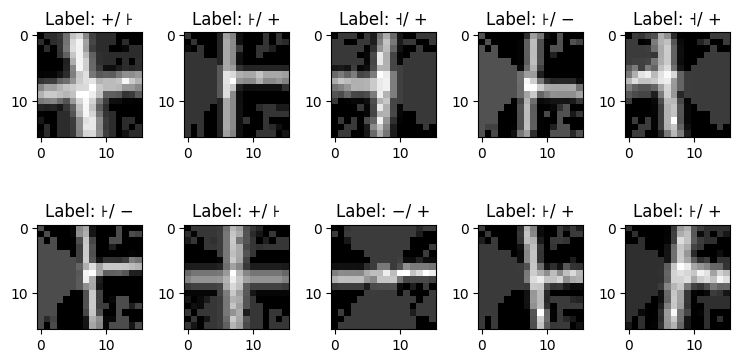

In [14]:
perturbed_X_train = PGD(model, feats=feats_train[:100], labels=labels_train[:100], epsilon=0.1, alpha=0.01, 
                  num_iter=10, randomize=False, positive=False)

print(f'Benign accuracy: {accuracy(labels_train[:100], model(feats_train[:100]))}')
pred_adv = model(feats_train[:100] + perturbed_X_train[:100])
print(f'Adv accuracy: {accuracy(labels_train[:100], pred_adv)}')

# visualize the attack patterns
perturbed_X_orig = torch.reshape(perturbed_X_train, (100,16,16)).detach().numpy() 
perturbed_img = X_train_orig[:100] + perturbed_X_orig[:100]
show_images_pred(X=perturbed_img[10:], Y=labels_train[10:], pred=pred_adv.detach().numpy()[10:])
#np.save(file=f"./perturbations/perturbations-Fourier-32neurons-no_reg-ep20-PGD0-100_samples", arr=perturbed_X_orig)

In [ ]:
# here we can also check transferability by loading perturbations from other models

"""
path = './perturbations/perturbations-Fourier-32neurons-no_reg-ep20-PGD0-100_samples.npy'
perturbed_X_orig = np.load(path)
perturbed_X_train = torch.reshape(torch.from_numpy(perturbed_X_orig).float(), (100,256))

print(f'Benign accuracy: {accuracy(labels_train[:100], model(feats_train[:100]))}')
pred_adv = model(feats_train[:100]+perturbed_X_train[:100])
print(f'Adv accuracy: {accuracy(labels_train[:100], pred_adv)}')

# visualize the attack patterns
perturbed_img = X_train_orig[:100] + perturbed_X_orig[:100]
show_images_pred(X=perturbed_img[10:], Y=labels_train[10:], pred=pred_adv.detach().numpy()[10:])
"""